# Whitening with 1D projections

Plots to provide geometric intuition for our method described in https://arxiv.org/abs/2301.11955 .

TLDR: A statistically white density has unit variance along **all** possible directions; a non-white density does not.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Ellipse
from typing import Optional

## Plotting helper methods

In [6]:
def get_unit_vectors(n: int) -> np.ndarray:
    """
    Returns an array of n unit vectors between 0 and pi.

    Parameters:
        n (int): The number of unit vectors to return.

    Returns:
        ndarray: An array of shape (2, n) containing the unit vectors.
    """
    angles = np.linspace(0, np.pi, n)
    unit_vectors = np.vstack((np.cos(angles), np.sin(angles)))
    return unit_vectors


def plot_cov_ellipses(mean, cov, stdevs, ax=None, alpha=0.5, **kwargs):
    """
    Plots ellipses of given standard deviations at the specified mean using the provided covariance matrix.

    Parameters:
        mean (ndarray): 1D array of length N containing the mean values for each of the N dimensions.
        cov (ndarray): 2D array of shape (N,N) containing the covariance matrix.
        stdevs (list): List of standard deviations at which to draw the ellipses.
        ax (AxesSubplot): Optional. Matplotlib axis to plot on. Default is None, which creates a new figure and axis.
        alpha (float): Optional. The alpha value (transparency) of the ellipses. Default is 0.5.

    Returns:
        axes (AxesSubplot): The matplotlib axis object.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for std in stdevs:
        # Calculate the covariance ellipse
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:,order]
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        ellipse = Ellipse(xy=mean, width=2*std*np.sqrt(vals[0]),
                          height=2*std*np.sqrt(vals[1]), angle=theta, alpha=alpha, **kwargs)
        ax.add_artist(ellipse)

    return ax


def plot_origin_line(theta, x_min=-1, x_max=1, n_pts=101, ax=None, **kwargs):
    """
    Plots a line passing through the origin with a specified slope, defined by the input x_min and x_max values.

    Parameters:
        theta (float): The angle in radians between the x-axis and the line.
        x_min (float): Optional. The minimum x-value of the line. Default is -1.
        x_max (float): Optional. The maximum x-value of the line. Default is 1.
        n_pts (int): Optional. The number of points to use when drawing the line. Must be odd, with the center point at the origin. Default is 101.
        ax (AxesSubplot): Optional. Matplotlib axis to plot on. Default is None, which creates a new figure and axis.
        **kwargs: Additional keyword arguments to pass to the plot function.

    Returns:
        axes (AxesSubplot): The matplotlib axis object.
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Generate the points for the line
    x_vals = np.linspace(x_min, x_max, n_pts)
    y_vals = np.zeros_like(x_vals)

    # Rotate the points by theta
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    points = np.vstack((x_vals, y_vals))
    points = np.dot(rot_matrix, points)

    # Plot the line
    ax.plot(points[0], points[1], **kwargs)
    return ax

def unnormalized_gaussian(x_min, x_max, stdev, n_pts=101):
    """
    Returns an unnormalized Gaussian distribution between x_min and x_max with standard deviation stdev, centered at 0.

    Parameters:
        x_min (float): The minimum value of x.
        x_max (float): The maximum value of x.
        stdev (float): The standard deviation of the Gaussian distribution.

    Returns:
        x (ndarray): A 1D numpy array of x-values.
        y (ndarray): A 1D numpy array of y-values, representing the unnormalized Gaussian distribution.
    """
    x = np.linspace(x_min, x_max, n_pts)
    y = np.exp(-0.5 * (x / stdev) ** 2)
    return x, y


def segmented_vertical_line(x, n, y_min=-3, y_max=3, colors=None, ax=None, **kwargs):
    """
    Creates a vertical line at x with n non-overlapping segments centered at 0,
    between y_min=-3 and y_max=3, and with a different color for each segment.

    Parameters:
        x (float): The x-value of the vertical line.
        n (int): The number of segments to create.
        ax (AxesSubplot, optional): The matplotlib AxesSubplot to plot on.

    Returns:
        ax (AxesSubplot): The matplotlib AxesSubplot with the plotted segmented line.
    """
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, n))
    if ax is None:
        fig, ax = plt.subplots()

    y_range = np.linspace(y_min, y_max, n + 1)

    for i in range(n):
        y = np.linspace(y_range[i], y_range[i+1], 2)
        ax.plot(x * np.ones_like(y), y, color=colors[i], **kwargs)

    return ax


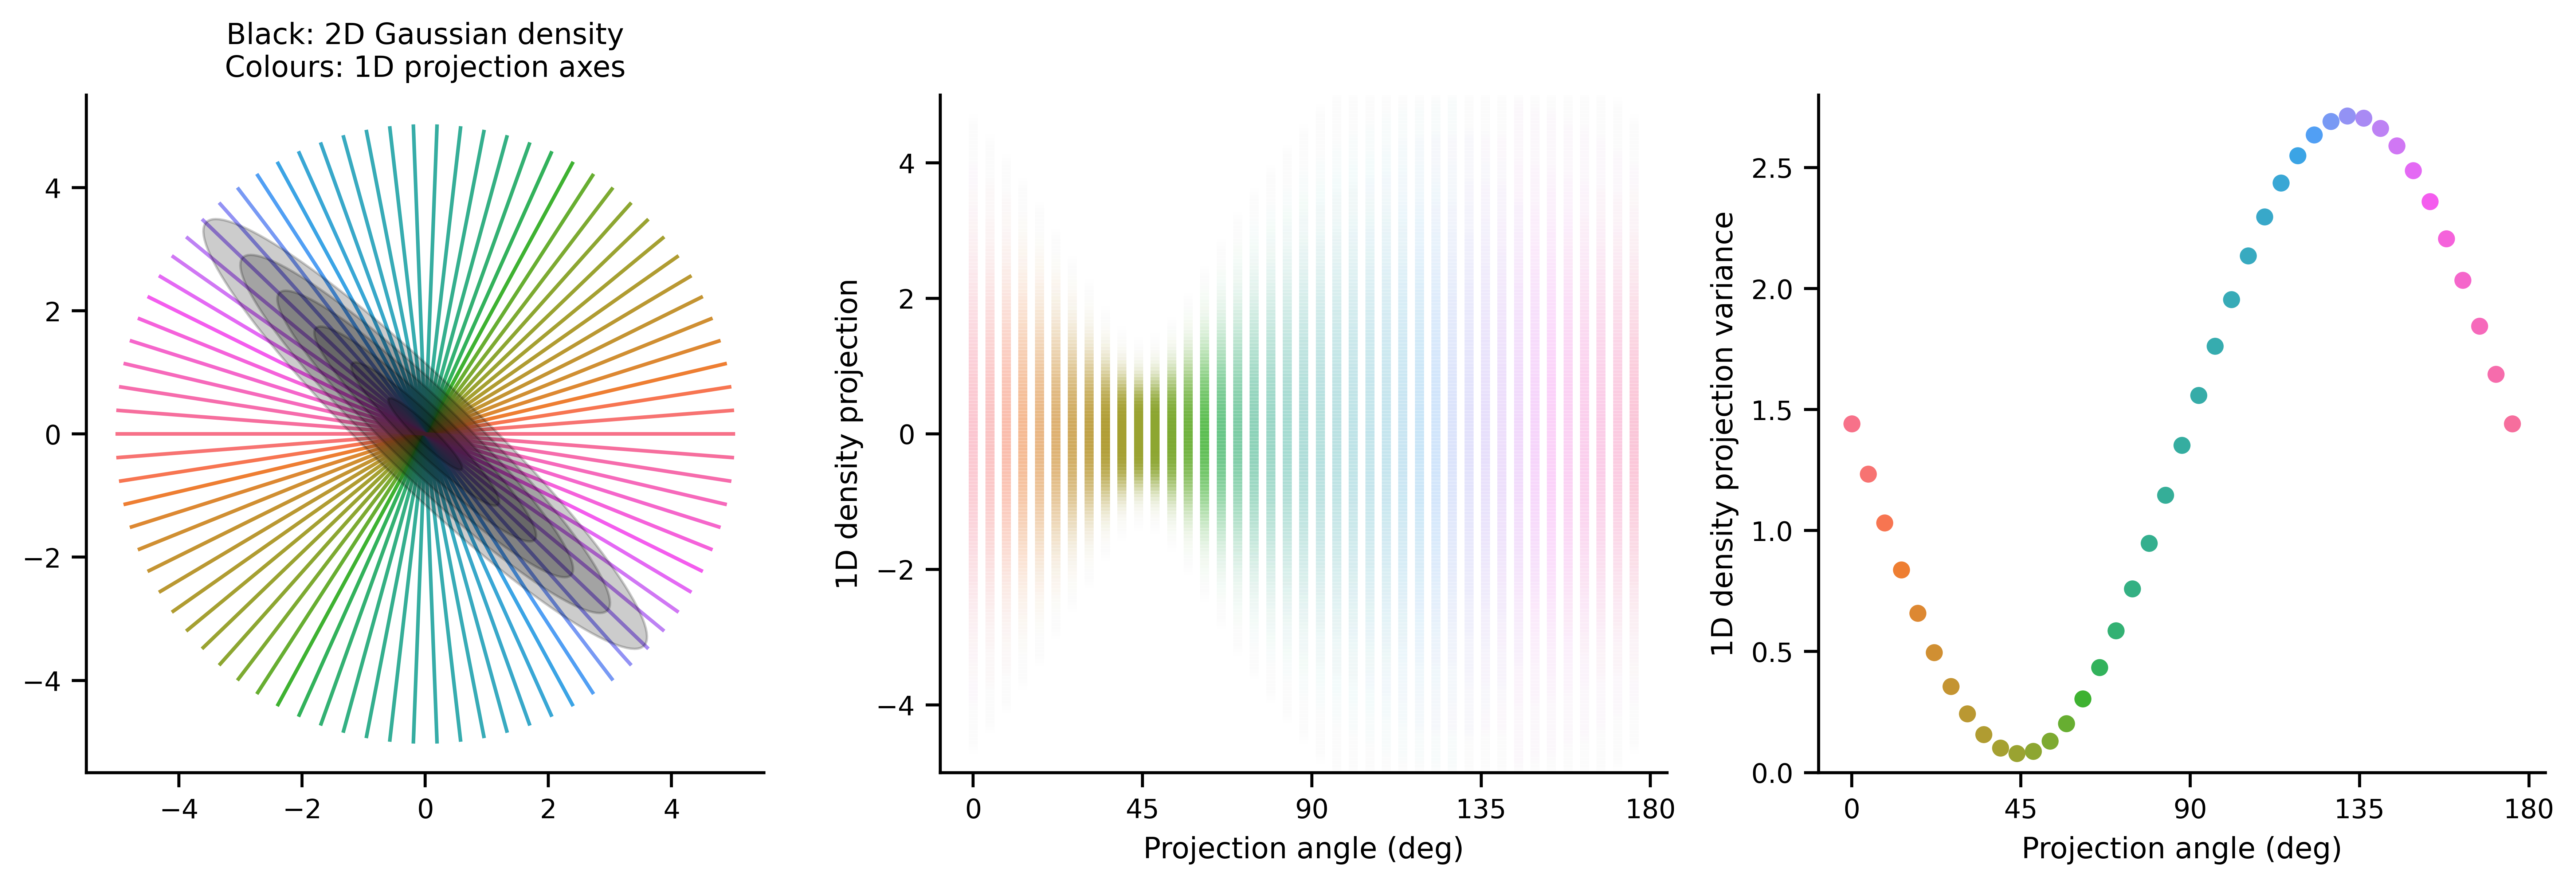

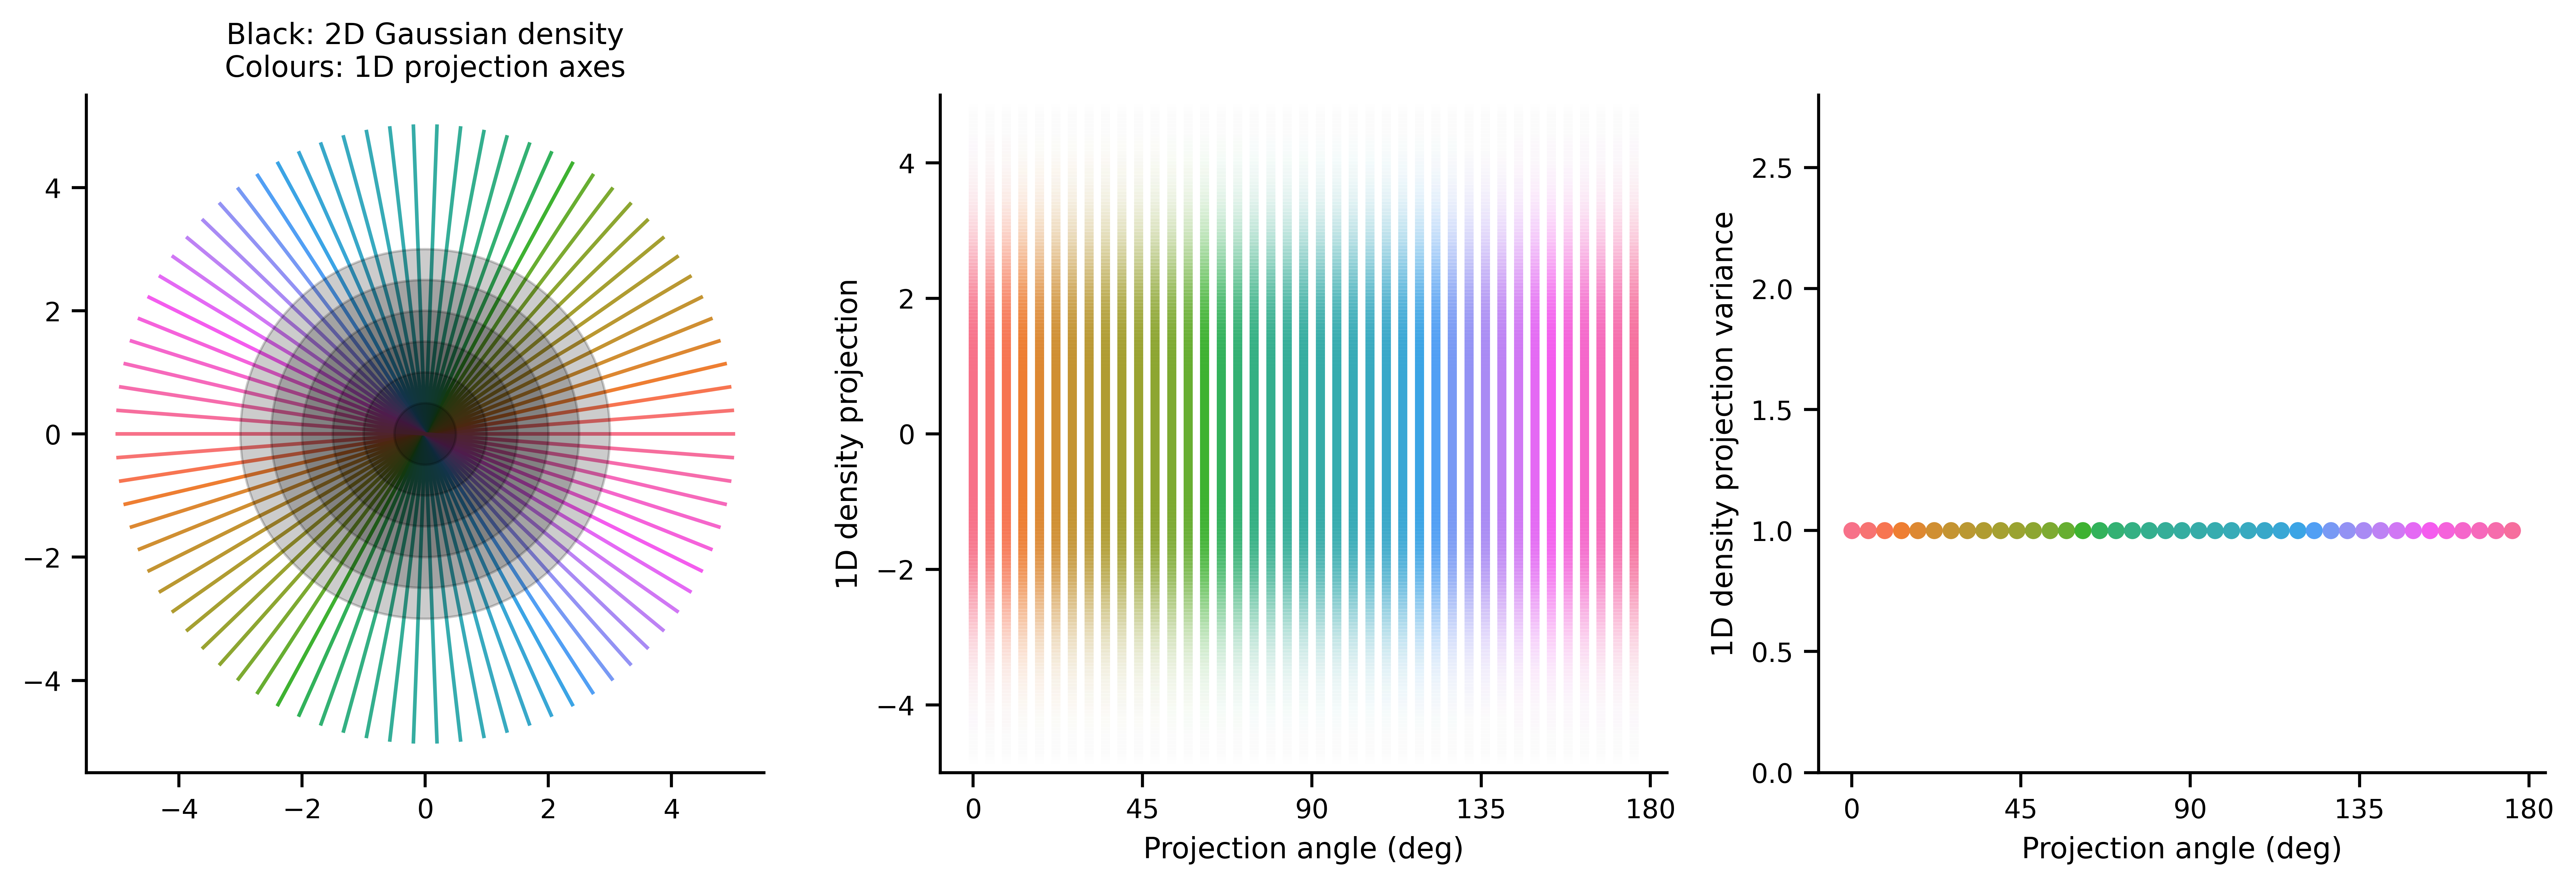

In [12]:
def plot_all(C, n_proj=41, m=201, dr=0.5):
    """Plot 3 panels.
    0: the Gaussian density of C and projection axes.
    1: The 1D projections.
    2: The variances.
    """
    mu = np.zeros(2)
    lims = (-5, 5)
    
    n_proj = 41
    P = get_unit_vectors(n_proj)
    dt = 180/n_proj
    theta = np.arange(0, 180, dt)
    cols = sns.color_palette('husl', n_proj)
    
    proj_stdevs = np.sqrt(np.diag(P.T @ C @ P))
    m = 201
    dr = 0.5
    # proj_lims = (-4, 4)
    proj_lims = lims
    with sns.plotting_context('paper'):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=600)
        for i, t in enumerate(theta):
        
            plot_origin_line(np.deg2rad(t), lims[0], lims[1], 10, ax=ax[0], color=cols[i], zorder=-1)
            
            y_vals, alphas = unnormalized_gaussian(-3, 3, proj_stdevs[i], m)
            alphas /= (proj_stdevs[i] / np.min(proj_stdevs))
            # alphas -= min(alphas)  # clip Gaussian within y-limits
            # alphas /= max(alphas)  # renorm
            alphas = alphas ** 1.5  # decay faster
            colors = [np.concatenate([cols[i], [a]]) for a in alphas]
            # colors = [(0,0,0,a) for a in alphas]  # black 1D densitites
            segmented_vertical_line(t, m, proj_lims[0], proj_lims[1], colors, ax=ax[1], linewidth=3)
            ax[2].scatter(t, proj_stdevs[i]**2, color=cols[i])
        
        plot_cov_ellipses(mu, C, np.arange(0.5, 3+dr, dr), ax=ax[0], alpha=.2, color='k', zorder=0)
        
        ax[0].set(xlim=lims, ylim=lims, title='Black: 2D Gaussian density\nColours: 1D projection axes')
        ax[0].axis('square')
        ax[1].set(
                xlabel='Projection angle (deg)', 
                ylabel='1D density projection',
                xticks=(0, 45, 90, 135, 180),
                ylim=proj_lims,
                )
        
        ax[2].set(ylabel='1D density projection variance', xlabel='Projection angle (deg)',
                xticks=(0, 45, 90, 135, 180),
                ylim=(0, 2.8))
    
        # Adjust spacing between panels
        fig.tight_layout()
        sns.despine()

seed = 42069
rng = np.random.default_rng(seed)
N = 2
eps = 1E-2
C = rng.standard_normal((N, N))
C = C @ C.T

plot_all(C)
plot_all(np.eye(2))